In [1]:
import sys
sys.path.append("/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI")
from BNN_Comparison.TyXe import tyxe
from torch import nn
from pyro import distributions as dist
import pyro
import pyro.infer.autoguide as ag
import torch
from BasicExample.datasets.Regression.toydataset import create_dataset, sinus_mapping, dataset_to_loader
from matplotlib import pyplot as plt

### Load dataset

In [2]:
data_noise = 0.2
n_datapoints = 256
x_train, y_train, x_test, y_test = create_dataset(lower=-5, upper=7, mapping=sinus_mapping,cluster_pos=[-0.5,2], data_noise=data_noise, n_datapoints=n_datapoints)
x_test = torch.unsqueeze(x_test, dim=-1)

# batch train set
train_set, test_set = dataset_to_loader(x_train, y_train, x_test, y_test , batch_size=16)

### Hyperparameters

In [3]:
epochs=1000
lr = 1e-4
prior_std = 1
weight_decay = 0 #0.5/prior_std

### Init standard model

In [4]:
net_MAP = nn.Sequential(nn.Linear(1, 200), nn.Tanh(), nn.Linear(200, 100), nn.Tanh(), nn.Linear(100, 1))
optim_MAP = torch.optim.Adam(net_MAP.parameters(), lr=lr, weight_decay=weight_decay)
loss_fun_MAP = torch.nn.MSELoss()
net_MAP_tracking_ll = net_MAP[-1].weight.detach().clone()
net_MAP_tracking = torch.cat([net_MAP[0].weight.detach().clone().flatten(), net_MAP[2].weight.detach().clone().flatten(), net_MAP[4].weight.detach().clone().flatten()], dim=0).unsqueeze(dim=0)

### Init Bayesian Model

In [5]:
torch.manual_seed(5)
net = nn.Sequential(nn.Linear(1, 200), nn.Tanh(), nn.Linear(200, 100), nn.Tanh(), nn.Linear(100, 1))
net.load_state_dict(net_MAP.state_dict())
prior = tyxe.priors.IIDPrior(dist.Normal(0, prior_std))
kl_div_scaling_factor=1
likelihood = tyxe.likelihoods.HomoskedasticGaussian(n_datapoints * kl_div_scaling_factor, scale=data_noise)
inference = tyxe.guides.AutoNormal
bnn = tyxe.VariationalBNN(net, prior, likelihood, inference)
optim = pyro.optim.Adam({"lr": lr})
net_tracking_ll = net_MAP[-1].weight.detach().clone()
net_tracking = torch.cat([net[0].weight.detach().clone().flatten(), net[2].weight.detach().clone().flatten(), net[4].weight.detach().clone().flatten()], dim=0).unsqueeze(dim=0)

### Training

In [6]:
for epoch in range(epochs):
    for data, target in train_set:
        optim_MAP.zero_grad()
        prediction = net_MAP(data)
        loss = loss_fun_MAP(prediction, target)
        loss.backward()
        optim_MAP.step()
        if (epoch % 10 ) == 0:
            print(f"Epoch {epoch}, loss {round(loss.item(), 2)} ", end="\r")
    net_MAP_tracking_ll = torch.cat((net_MAP_tracking_ll, net_MAP[-1].weight.detach()), dim=0)
    layer = torch.cat([net_MAP[0].weight.detach().clone().flatten(), net_MAP[2].weight.detach().clone().flatten(), net_MAP[4].weight.detach().clone().flatten()], dim=0)
    net_MAP_tracking = torch.cat([net_MAP_tracking, layer.unsqueeze(dim=0)], dim=0)


In [7]:
def print_epoch(_, epoch, elbo):
    if (epoch % 10 ) == 0:
        print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")

with tyxe.poutine.local_reparameterization():
    for epoch in range(epochs):
        print_epoch_i = lambda x, y, elbo: print_epoch(x, epoch, elbo)
        bnn.fit(train_set, optim, 1, callback=print_epoch_i)
        layer = torch.cat([net[0].weight.detach().clone().flatten(), net[2].weight.detach().clone().flatten(), net[4].weight.detach().clone().flatten()], dim=0)
        net_tracking = torch.cat([net_tracking, layer.unsqueeze(dim=0)], dim=0)
        net_tracking_ll = torch.cat((net_tracking_ll, net[-1].weight.detach()), dim=0)

In [8]:
net_MAP_tracking = torch.nan_to_num(net_MAP_tracking)

### Trajectories plotting

In [9]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch

def plot_trajectories(traj, axs, splits, labels=("Laplace", "VI"), color=["red", "blue", "green"]):
    pca = PCA(n_components=2)
    projection = pca.fit_transform(traj)
    for idx, (start, end) in enumerate(zip([0]+splits, splits+[traj.shape[0]-1])):
        # axs.scatter(projection[start:end, 0], projection[start:end, 1], s=10, label=labels[idx])
        axs.plot(projection[start:end, 0], projection[start:end, 1], label=labels[idx], color=color[idx])
        mid = start+int((end-start)/2)
        axs.arrow(projection[mid][0], projection[mid][1], (projection[mid+1] - projection[mid])[0], (projection[mid+1] - projection[mid])[1])
    return pca, projection

Text(0.5, 1.0, 'Last layer')

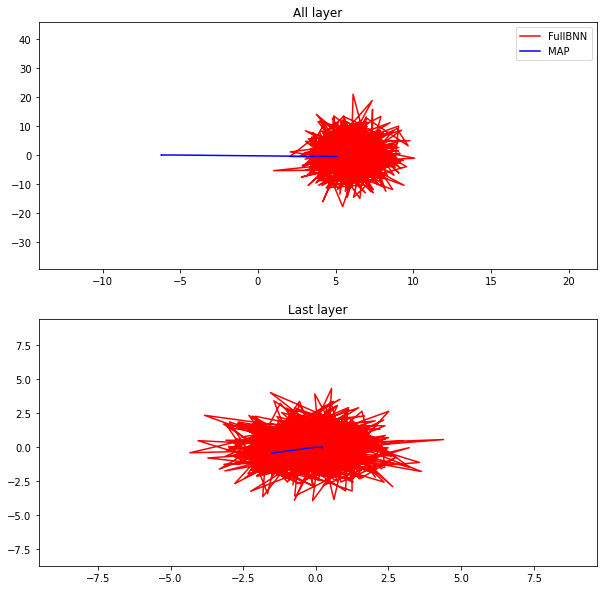

In [10]:
fig, (axs, axs2) = plt.subplots(2, figsize=(10,10))
pca, projection = plot_trajectories(torch.cat([net_tracking, net_MAP_tracking], dim=0), axs,
 splits = [epochs], labels=["FullBNN", "MAP"]);
pca_ll, projection_ll = plot_trajectories(torch.cat([net_tracking[:, -100:], net_MAP_tracking[:, -100:]], dim=0), axs2,
 splits = [epochs], labels=["FullBNN", "MAP"]);
axs.legend()
axs.set_xlim(axs.get_xlim()[0]*2, axs.get_xlim()[1]*2)
axs.set_ylim(axs.get_ylim()[0]*2, axs.get_ylim()[1]*2)
axs2.set_xlim(axs2.get_xlim()[0]*2, axs2.get_xlim()[1]*2)
axs2.set_ylim(axs2.get_ylim()[0]*2, axs2.get_ylim()[1]*2)
axs.set_title("All layer")
axs2.set_title("Last layer")

In [11]:
@torch.no_grad()
def plot_loss(pca:PCA, baseline_model, x_bounds, y_bounds, dataset, axs, steps=10):
    loss_fun = torch.nn.MSELoss(reduction="sum")
    old_params = baseline_model[-1].weight.data.detach().clone()
    x_lin = torch.linspace(x_bounds[0], x_bounds[1], steps=steps)
    y_lin = torch.linspace(y_bounds[0], y_bounds[1], steps=steps)
    loss_grid = torch.zeros((steps, steps))
    for idx, x in enumerate(x_lin):
        for idy, y in enumerate(y_lin):
            new_weights = pca.inverse_transform(torch.tensor([x,y]))
            baseline_model[-1].weight.data = torch.unsqueeze(torch.from_numpy(new_weights).float(), dim=0)
            for data, target in dataset:
                loss_grid[idx, idy] += loss_fun(baseline_model(data), target)
    loss_grid /= n_datapoints
    baseline_model[-1].weight.data = old_params
    return axs.contourf(x_lin, y_lin, loss_grid, zorder=0, alpha=0.5)

In [12]:
@torch.no_grad()
def plot_full_loss(pca:PCA, baseline_model:torch.nn.Module, x_bounds, y_bounds, dataset, axs, steps=10):
    loss_fun = torch.nn.MSELoss(reduction="sum")
    old_state_dict = baseline_model.state_dict()
    x_lin = torch.linspace(x_bounds[0], x_bounds[1], steps=steps)
    y_lin = torch.linspace(y_bounds[0], y_bounds[1], steps=steps)
    loss_grid = torch.zeros((steps, steps))
    for idx, x in enumerate(x_lin):
        for idy, y in enumerate(y_lin):
            new_weights = pca.inverse_transform(torch.tensor([x,y]))
            baseline_model[0].weight.data = torch.from_numpy(new_weights[:200]).float().view(200,1)
            baseline_model[2].weight.data = torch.from_numpy(new_weights[200:-100]).float().view(100,200)
            baseline_model[4].weight.data = torch.from_numpy(new_weights[-100:]).float().view(1,100)
            for data, target in dataset:
                loss_grid[idx, idy] += loss_fun(baseline_model(data), target)
    loss_grid /= n_datapoints
    baseline_model.load_state_dict(old_state_dict)
    return axs.contourf(x_lin, y_lin, loss_grid, zorder=0, alpha=0.5)

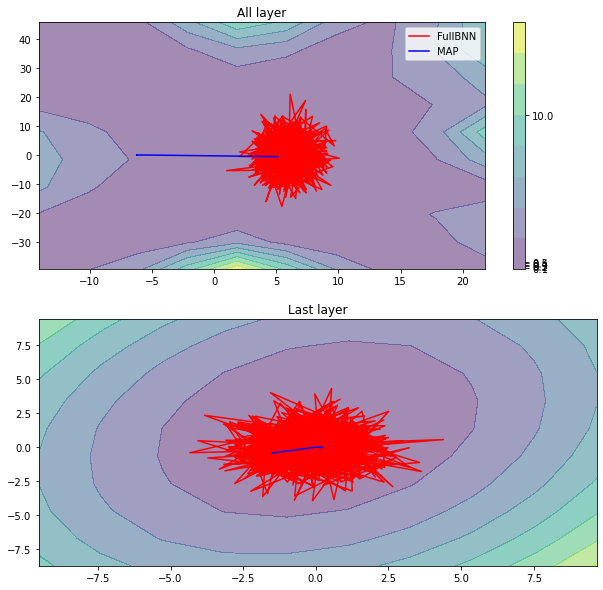

In [13]:
expansion = 1
cmap = plot_loss(pca_ll, net_MAP, (axs2.get_xlim()[0]*expansion,axs2.get_xlim()[1]*expansion), (axs2.get_ylim()[0]*expansion, axs2.get_ylim()[1]*expansion), train_set, axs2, steps=10)
cmap = plot_full_loss(pca, net_MAP, (axs.get_xlim()[0]*expansion,axs.get_xlim()[1]*expansion), (axs.get_ylim()[0]*expansion, axs.get_ylim()[1]*expansion), train_set, axs, steps=10)
fig.colorbar(cmap, ax=axs, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 10])
fig

### Inference

In [14]:
predictions= []
for i in range(x_test.shape[0]):
    predictions.append(bnn.predict(x_test[i], num_predictions=100))

predictions = torch.tensor(predictions)

(-3.0, 3.0)

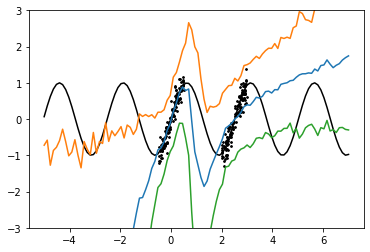

In [15]:
fig, ax = plt.subplots()
ax.plot(x_test, y_test, color="black", label="True function")
ax.scatter(x_train, y_train, s=3, color="black")
mean = predictions[:,0]
std = predictions[:,1]
ax.plot(x_test, mean)
ax.plot(x_test, mean + 2 * std)
ax.plot(x_test, mean - 2 * std)
ax.set_ylim(-3, 3)